# Introduction

The aim of this project is to compete in a Kaggle competition, where people create algorithms and compete against machine learning practitioners around the world. 

Kaggle has created a number of competitions designed for beginners. The one we'll be looking at is about predicting which passengers survived the sinking of the Titanic.

We have a data set of different information about passengers onboard the Titanic, and we see if we can use that information to predict whether those people survived or not.

In this competition, the two files are named test.csv and train.csv. 

We'll start by using the pandas library to read both files and inspect their size.

In [1]:
import pandas as pd

train = pd.read_csv("train.csv")
holdout = pd.read_csv("test.csv")

In [2]:
train_shape = train.shape
holdout_shape = holdout.shape

print(train_shape, holdout_shape)

(891, 12) (418, 11)


In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_null_counts = train.isnull().sum()
print(train_null_counts[train_null_counts>0])


holdout_null_counts = holdout.isnull().sum()
print(holdout_null_counts[holdout_null_counts>0])


Age         177
Cabin       687
Embarked      2
dtype: int64
Age       86
Fare       1
Cabin    327
dtype: int64


Because the ultimate aim of this project is to predict whether the passengers survived or not, there are only two possible outcomes. Therefore, the type of machine learning we will be doing is binary classification. 

In order to understand this topic more thoroughly, we are going to dive in and think about what variables can strongly affect the outcome.

Anyone who has watched the movie Titanic would remember that women and children were given preference to lifeboats (as they were in real life). You would also remember the vast class disparity of the passengers.

This indicates that Age, Sex, and PClass may be good predictors of survival. We'll start by exploring Sex and Pclass by visualizing the data.

Because the Survived column contains 0 if the passenger did not survive and 1 if they did, we can segment our data by sex and pClass and calculate the mean of this column.

In [5]:
initial_explore_cols = ["Sex","Pclass", "Age"]
initial_explore = train[initial_explore_cols].copy()
initial_explore.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
Sex       891 non-null object
Pclass    891 non-null int64
Age       714 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 21.0+ KB


Sex and Pclass columns are categorical but Age is continous numerical. Therefore, we will explore Age column in a different manner. 

We will first explore Sex and Pclass columns.

<IPython.core.display.Javascript object>


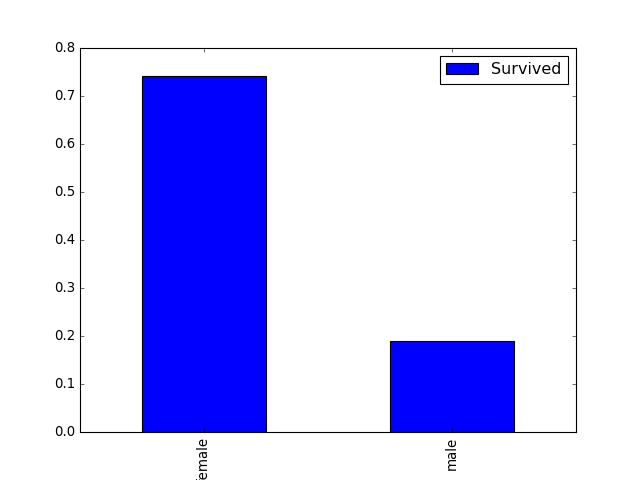

In [26]:
import matplotlib.pyplot as plt

%matplotlib notebook
sex_pivot = train.pivot_table(index="Sex",values="Survived")
sex_pivot.plot.bar()
plt.show()


<IPython.core.display.Javascript object>


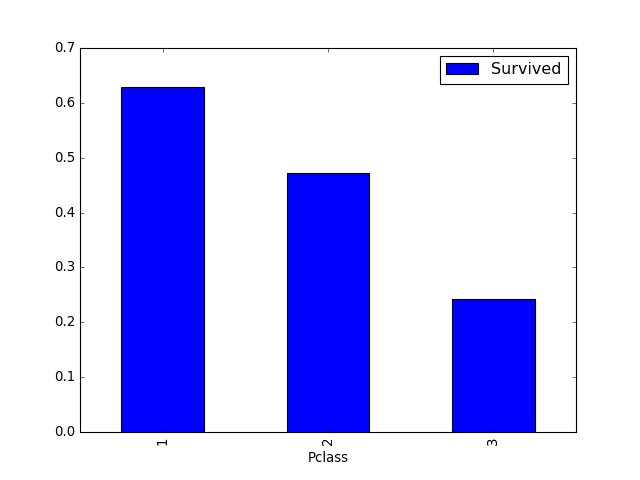

In [34]:
import matplotlib.pyplot as plt
%matplotlib notebook
pclass_pivot = train.pivot_table(index="Pclass",values="Survived")
pclass_pivot.plot.bar()
plt.show()

Let's then explore Age column, first by looking at its description. 

In [35]:
print(train["Age"].describe())

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64


The Age column contains numbers ranging from 0.42 to 80.0.

The other thing to note here is that there are 714 values in this column, fewer than the 891 rows we discovered that the train data set had earlier in this mission which indicates we have some missing values.

One way to look at distribution of values in a continuous numerical set is to use histograms. We can create two histograms to compare visually the those that survived vs those who died across different age ranges:

<IPython.core.display.Javascript object>


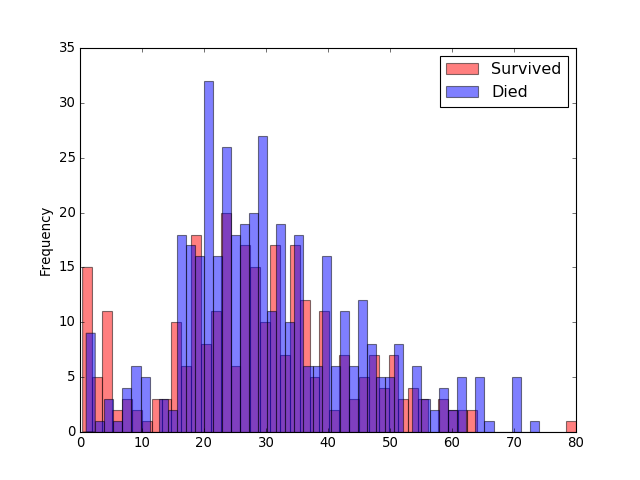

In [36]:
import matplotlib.pyplot as plt
%matplotlib notebook

survived = train[train["Survived"] == 1]
died = train[train["Survived"] == 0]
survived["Age"].plot.hist(alpha=0.5,color='red',bins=50)
died["Age"].plot.hist(alpha=0.5,color='blue',bins=50)
plt.legend(['Survived','Died'])
plt.show()

The relationship here is not simple, but we can see that in some age ranges more passengers survived - where the red bars are higher than the blue bars.

In order for this to be useful to our machine learning model, we can separate this continuous feature into a categorical feature by dividing it into ranges.

# Preprocessing the Data

There are fields other than sex, age and pclass that we may find relevant to this survival rate. 

There are values missing for several columns that we may find helpful. So we will clean and proess the missing values first. 

Let's create a functioni that fills missing values of "Fare" column with the average value and fills missing values of "Embarked" column with "S". We will show this in the next session. 

In [37]:
# %load functions.py
def process_missing(df):
    #Handle various missing values from the data set

    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

Let's create a function that fills missing age with -0.5 and puts the ages into different buckets, so that we can convert the continous numerical values into categorical values. 

In [38]:
def process_age(df):
    #Process the Age column into pre-defined 'bins' 

    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

Let's create a function that separate "Fare" column into different buckets. 

In [39]:
def process_fare(df):
    #Process the Fare column into pre-defined 'bins' 

    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

Let's createa function that creates a new column for cabin type. 

In [40]:
def process_cabin(df):
    #Process the Cabin column into pre-defined 'bins' 

    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

This function then divides the passengers by using their titles.

In [41]:
def process_titles(df):
    #Extract and categorize the title from the name column 

    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

In [42]:
def create_dummies(df,column_name):
    #Create Dummy Columns (One Hot Encoding) from a single Column

    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

Missing values are filled, data is divided into different buckets for better clarification. This is applied to both training and holdout data.

In [43]:
def pre_process(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)

    for col in ["Age_categories","Fare_categories",
                "Title","Cabin_type","Sex"]:
        df = create_dummies(df,col)
    
    return df

train = pre_process(train)
holdout = pre_process(holdout)

In [44]:
train.head() # with dummies.

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown,Sex_female,Sex_male
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,0,0,0,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,1,0,0,0,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,0,0,1,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,1,0,0,0,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,0,0,0,0,0,0,1,0,1


# Exploring the Data

Let's look at Sibsp and Parch, now that we processed the columns listed above. 

"Sibsp" and "Parch" are the two columns that contain information about the family members each passenger had onboard. 

Let's use Pandas and matplotlib to explore those two columns. 

In [45]:
explore_cols = ["SibSp","Parch","Survived"]
explore = train[explore_cols].copy()
explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
SibSp       891 non-null int64
Parch       891 non-null int64
Survived    891 non-null int64
dtypes: int64(3)
memory usage: 21.0 KB


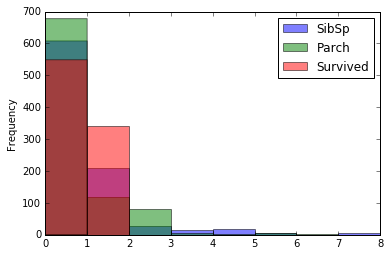

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

explore.plot.hist(alpha=0.5,bins=8)
plt.show()

The histogram above shows the survival frequency for each number of siblings or parent/children that accompanied each passenger. 

Since it looks convoluted with three colors, we will remove survived key. 

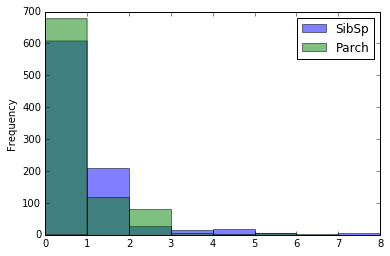

In [47]:
explore.drop("Survived",axis=1).plot.hist(alpha=0.5,bins=8)
plt.show()

In [1]:
explore["familysize"] = explore[["SibSp","Parch"]].sum(axis=1)
explore.drop("Survived",axis=1).plot.hist(alpha=0.5,bins=8)
explore.plot.hist(alpha=0.5,bins=10)
plt.xticks(range(11))
plt.show()

NameError: name 'explore' is not defined

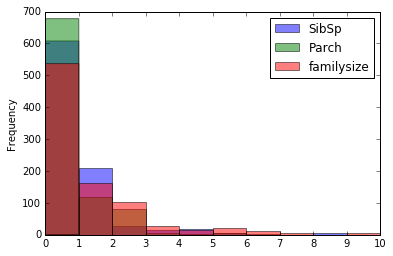

In [15]:
explore.drop("Survived",axis=1).plot.hist(alpha=0.5,bins=10)
plt.xticks(range(11))
plt.show()

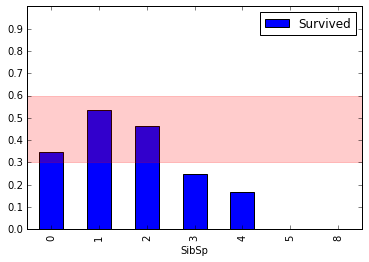

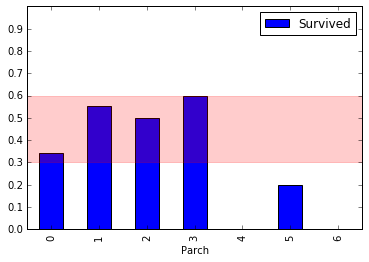

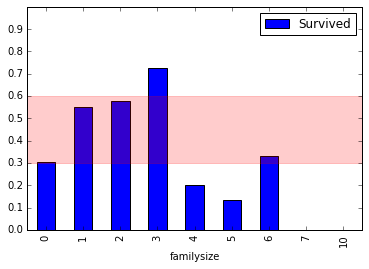

In [16]:
import numpy as np

for col in explore.columns.drop("Survived"):
    pivot = explore.pivot_table(index=col,values="Survived")
    pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
    plt.axhspan(.3, .6, alpha=0.2, color='red')
    plt.show()

The SibSp column shows the number of siblings and/or spouses each passenger had on board, while the Parch columns shows the number of parents or children each passenger had onboard. Neither column has any missing values.

The distribution of values in both columns is skewed right, with the majority of values being zero.

I summed these two columns to explore the total number of family members each passenger had onboard. The shape of the distribution of values in this case is similar, however there are less values at zero, and the quantity tapers off less rapidly as the values increase.

Looking at the survival rates of the the combined family members, it is evident that few of the over 500 passengers with no family members survived, while greater numbers of passengers with family members survived.

# Engineering New Features

We want to indicate whether the passenger onboarded alone or not. 
We will put 0 for is not alone, and 1 for is alone. 

In [17]:
def process_isalone(df):
    df["familysize"] = df[["SibSp","Parch"]].sum(axis=1)
    df["isalone"] = 0
    df.loc[(df["familysize"] == 0),"isalone"] = 1
    df = df.drop("familysize",axis=1)
    return df

train = process_isalone(train)
holdout = process_isalone(holdout)

10 fold cross validation for Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV #recursive feature elimination and cross val.

def select_features(df):
# Remove non-numeric columns, columns that have null values
    df = df.select_dtypes([np.number]).dropna(axis=1)
    all_X = df.drop(["Survived","PassengerId"],axis=1)
    all_y = df["Survived"]
    
    clf = RandomForestClassifier(random_state=1) #Make a decision tree
    selector = RFECV(clf,cv=10) #Select the most important (column) out of 10
    selector.fit(all_X,all_y) #Then, train the selection
    
    best_columns = list(all_X.columns[selector.support_]) #best columns
    print("Best Columns \n"+"-"*12+"\n{}\n".format(best_columns))
    
    return best_columns

cols = select_features(train)
# takes "train" df, edit and separate df
# run random forest (decision tree), select relevant columns
# fit df to the selected columms
# Reveal best columns -- through random forest & RFECV

Best Columns 
------------
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Young Adult', 'Fare_categories_12-50', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'isalone']



/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

#Choosing the best params, outputting scores for the best cols (features)
#Testing each parameter combination for each estimator (model)
def select_model(df, features): 
    all_X = df[features]
    all_y = df["Survived"]
    # List of dictionaries, each containing a model name,
    # it's estimator and a dict of hyperparameters
    models = [
        {"name": "LogisticRegression", 
        "estimator": LogisticRegression(),
        "hyperparameters": {
            "solver": ["newton-cg", "lbfgs", "liblinear"]
        }},
        {"name": "KNeighborsClassifier", 
        "estimator": KNeighborsClassifier(),
        "hyperparameters": {
            "n_neighbors": range(1,20,2),
            "weights": ["distance", "uniform"],
            "algorithm": ["ball_tree", "kd_tree", "brute"],
            "p": [1,2]
        }},
        {"name": "RandomForestClassifier", 
        "estimator": RandomForestClassifier(),
        "hyperparameters": {
            "n_estimators": [4,6,9],
            "criterion": ["entropy", "gini"],
            "max_depth": [2, 5, 10],
            "max_features": ["log2", "sqrt"],
            "min_samples_leaf": [1, 5, 8],
            "min_samples_split": [2, 3, 5]
        }}
    ]
    for model in models:
        print(model['name'])
        print("-" * len(model['name']))
        grid = GridSearchCV(model['estimator'], 
                            param_grid=model['hyperparameters'], cv=10)
        grid.fit(all_X, all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_
        
        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

    return models

result = select_model(train, cols)

LogisticRegression
------------------
Best Score: 0.8204264870931538
Best Parameters: {'solver': 'liblinear'}

KNeighborsClassifier
--------------------
Best Score: 0.7755331088664422
Best Parameters: {'p': 1, 'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'brute'}

RandomForestClassifier
----------------------
Best Score: 0.8372615039281706
Best Parameters: {'min_samples_leaf': 1, 'n_estimators': 9, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 3}



In [33]:
import numpy as np
result_np = np.asarray(result)
result_np.shape

(3,)

In [34]:
def save_submission_file(model, cols, filename="submission.csv"):
    holdout_data = holdout[cols]
    predictions = model.predict(holdout_data)
    
    #for submission
    holdout_ids = holdout["PassengerId"]
    submission_df = {"PassengerId": holdout_ids,
                 "Survived": predictions}
    submission = pd.DataFrame(submission_df)
    submission.to_csv(filename,index=False)

best_rf_model = result[2]["best_model"]
save_submission_file(best_rf_model,cols)